In [1]:
import torch 
import numpy as np
from matplotlib import pyplot as plt
import time

from solver import Solver
from dataset import SytheticData

In [2]:
# Device 
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(f'device={device}')

device=cuda


In [3]:
# Mesh Configurations
# h = 0.030
h = 0.01
dt = 0.0010
nx = nz = 100
nt = 800
f0 = 10
t0 = 1/f0

cfl = 4 * dt / h
npw = 4 / f0 / h
print('CFL number is about' + f' {cfl:.2f}')
print('Number of grid points per wave length is about' + f' {npw:.1f}')

CFL number is about 0.40
Number of grid points per wave length is about 40.0


In [4]:
# Training configurations
num_epochs = 200
batch_size = 16
learning_rate = 0.001
shuffle = True

In [6]:
# Sources and receivers
sx = np.arange(1, 100, 2)
sources_xz1 = np.c_[np.ones_like(sx), sx]
sources_xz2 = np.c_[sx, np.ones_like(sx)]
rx = np.arange(1, 100, 2)
receivers_xz1 = np.c_[99*np.ones_like(rx), rx]
receivers_xz2 = np.c_[rx, 99*np.ones_like(rx)]

In [12]:
# True model
rho = 1.5 * np.ones((nz+1, nx+1), dtype=np.float32)
rho[nz//3:2*nz//3, nx//3:2*nx//3] += 0.5
vp = 3.5 * np.ones((nz+1, nx+1), dtype=np.float32)
vp[nz//3:2*nz//3, nx//3:2*nx//3] += 0.8
vs = 2.4 * np.ones((nz+1, nx+1), dtype=np.float32)
vs[nz//3:2*nz//3, nx//3:2*nx//3] += 0.6

In [13]:
# Dataset and dataloader
rho_true = torch.from_numpy(rho)
vp_true = torch.from_numpy(vp)
vs_true = torch.from_numpy(vs)
dataset1 = SytheticData(rho_true, vp_true, vs_true, h, dt, nt, t0, f0, sources_xz1, receivers_xz1)
dataloader1 = torch.utils.data.DataLoader(dataset1, batch_size=batch_size, shuffle=shuffle)
dataset2 = SytheticData(rho_true, vp_true, vs_true, h, dt, nt, t0, f0, sources_xz2, receivers_xz2)
dataloader2 = torch.utils.data.DataLoader(dataset2, batch_size=batch_size, shuffle=shuffle)

In [15]:
# Initial model
rho_initial = 1.5 * torch.ones((nz+1, nx+1), dtype=torch.float32, device=device)
vp_initial = 3.5 * torch.ones((nz+1, nx+1), dtype=torch.float32, device=device)
vs_initial = 2.4 * torch.ones((nz+1, nx+1), dtype=torch.float32, device=device)
rho_initial_numpy = rho_initial.clone().cpu().numpy()
vp_initial_numpy = vp_initial.clone().cpu().numpy()
vs_initial_numpy = vs_initial.clone().cpu().numpy()
rho_initial.requires_grad = True
vp_initial.requires_grad = True
vs_initial.requires_grad = True

In [16]:
# Initial solver
solver_initial1 = Solver(rho_initial, vp_initial, vs_initial, h, dt, nt, t0, f0, receivers_xz1)
solver_initial2 = Solver(rho_initial, vp_initial, vs_initial, h, dt, nt, t0, f0, receivers_xz2)

In [17]:
# Loss function
criterion = torch.nn.MSELoss()

In [18]:
# Optimizer 
all_params = [rho_initial, vp_initial, vs_initial]
optimizer = torch.optim.Adam(all_params, lr=learning_rate)

In [19]:
# Logger 
loss_list = []

In [21]:
# Training
n_batch = 0
for n_epoch in range(num_epochs):
    for i, data in enumerate(dataloader1):
        n_batch += 1
        time_begin = time.time()
        sx, vx_obs, vy_obs = data 
        optimizer.zero_grad()
        vx, vy = solver_initial1.step(sx)
        loss_val = criterion(vx, vx_obs.to(device)) + criterion(vy, vy_obs.to(device)) # ?
        loss_val.backward()
        loss_list.append(loss_val.item())
        optimizer.step()
        time_end = time.time()
        print(f"Epoch {n_epoch+1}, Batch {n_batch}, loss={loss_val:.6f}, time={time_end - time_begin:.2f}s")
    for i, data in enumerate(dataloader2):
        n_batch += 1
        time_begin = time.time()
        sx, vx_obs, vy_obs = data 
        optimizer.zero_grad()
        vx, vy = solver_initial2.step(sx)
        loss_val = criterion(vx, vx_obs.to(device)) + criterion(vy, vy_obs.to(device)) # ?
        loss_val.backward()
        loss_list.append(loss_val.item())
        optimizer.step()
        time_end = time.time()
        print(f"Epoch {n_epoch+1}, Batch {n_batch}, loss={loss_val:.6f}, time={time_end - time_begin:.2f}s")

Epoch 1, Batch 1, loss=0.006446, time=4.56s
Epoch 1, Batch 2, loss=0.005597, time=4.47s
Epoch 1, Batch 3, loss=0.006649, time=4.60s
Epoch 1, Batch 4, loss=0.005523, time=5.45s
Epoch 1, Batch 5, loss=0.002340, time=4.90s
Epoch 1, Batch 6, loss=0.002261, time=4.16s
Epoch 1, Batch 7, loss=0.002250, time=4.11s
Epoch 1, Batch 8, loss=0.002221, time=4.37s
Epoch 2, Batch 9, loss=0.005337, time=4.17s
Epoch 2, Batch 10, loss=0.005495, time=4.20s
Epoch 2, Batch 11, loss=0.005812, time=4.09s
Epoch 2, Batch 12, loss=0.007091, time=4.70s
Epoch 2, Batch 13, loss=0.002130, time=5.06s
Epoch 2, Batch 14, loss=0.002134, time=4.10s
Epoch 2, Batch 15, loss=0.002104, time=4.83s
Epoch 2, Batch 16, loss=0.002021, time=4.16s
Epoch 3, Batch 17, loss=0.005235, time=4.17s
Epoch 3, Batch 18, loss=0.005186, time=3.76s
Epoch 3, Batch 19, loss=0.005163, time=3.73s
Epoch 3, Batch 20, loss=0.003530, time=3.71s
Epoch 3, Batch 21, loss=0.001881, time=3.79s
Epoch 3, Batch 22, loss=0.001980, time=3.78s
Epoch 3, Batch 23, 

In [23]:
rho_inversion = rho_initial.detach().cpu().numpy()
vp_inversion = vp_initial.detach().cpu().numpy()
vs_inversion = vs_initial.detach().cpu().numpy()

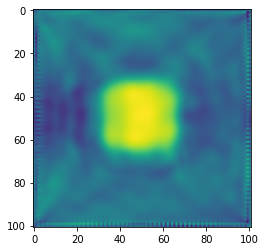

In [27]:
plt.imshow(vs_inversion)

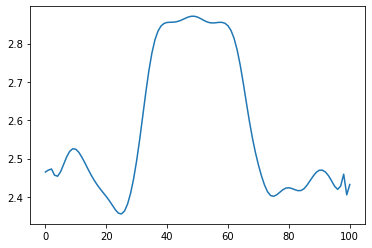

In [31]:
plt.plot(vs_inversion[:, 50])

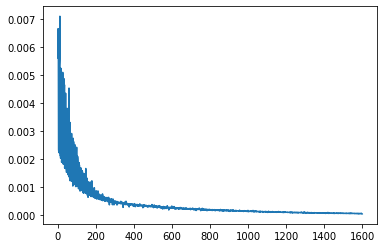

In [32]:
plt.plot(loss_list)

In [22]:
1600 * 4 /60

106.66666666666667